In [1]:
import sys
sys.path.append("/home/dongwan/uniseg")
from datasets.dataset_utils import get_dataset_categories

In [2]:
import torch
from PIL import Image
import numpy as np
import pickle
from datasets import dataset_factory
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
all_dataset_categories = get_dataset_categories('city_idd_bdd_mapillary')
cityscapes_categories = get_dataset_categories('cityscapes')

In [3]:
from collections import namedtuple
Label = namedtuple( 'Label' , ['name','id','trainId', 'category','categoryId','hasInstances','ignoreInEval','color'])
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [4]:
all_colors = {label.color for label in labels}
name2color = {label.name: label.color for label in labels if label.name in cityscapes_categories}
name2color.update({cls_name: (0, 0, 0) for cls_name in all_dataset_categories if cls_name not in name2color})
id2color = {i: name2color[label_name] for i, label_name in enumerate(sorted(list(name2color.keys())))}
remaining_colors = list(sorted(all_colors.difference(set(id2color.values()))))
remaining_colors

[(0, 0, 90),
 (0, 0, 110),
 (81, 0, 81),
 (111, 74, 0),
 (150, 100, 100),
 (150, 120, 90),
 (180, 165, 180),
 (230, 150, 140),
 (250, 170, 160)]

In [5]:
for i, cname in enumerate(['lane marking - general', 'lane marking - crosswalk', 'manhole', 'bicyclist', 
                          'trash can', 'traffic sign (back)', 'ego vehicle', 'curb']):
    c = remaining_colors[i]
    name2color[cname] = c
    id2color[all_dataset_categories.index(cname)] = c
    print(f"{cname}: {c}")

# on rails == train
name2color['on rails'] = name2color['train']
id2color[all_dataset_categories.index('on rails')] = id2color[all_dataset_categories.index('train')]

# motorcyclist
id2color[all_dataset_categories.index('motorcyclist')] = (147, 112, 219)

# lane marking
id2color[all_dataset_categories.index('lane marking - general')] = (255, 255, 255)

lane marking - general: (0, 0, 90)
lane marking - crosswalk: (0, 0, 110)
manhole: (81, 0, 81)
bicyclist: (111, 74, 0)
trash can: (150, 100, 100)
traffic sign (back): (150, 120, 90)
ego vehicle: (180, 165, 180)
curb: (230, 150, 140)


In [6]:
def visualize_images(num_cols=2, num_rows=2, img_list=None, names=None, fig_size=(20, 10), title=None):
    fig = plt.figure(figsize=fig_size)
    fig.suptitle(title, fontsize=15) if title is not None else None
    for i in range(num_rows):
        for j in range(num_cols):
            idx = num_cols * i + j + 1
            if len(img_list) > idx - 1:
                ax = fig.add_subplot(num_rows, num_cols, idx)
                img = img_list[idx - 1]
                if isinstance(img, torch.Tensor):
                    vmin, vmax = 0, 1
                else:
                    vmin, vmax = None, None
                plt.imshow(img_list[idx - 1], vmin=vmin, vmax=vmax)
                plt.title(names[idx - 1]) if names is not None else None
                ax.axes.get_xaxis().set_visible(False)
                ax.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

def save_images(save_path, num_cols=2, num_rows=2, img_list=None, names=None, fig_size=(20, 10), title=None):
    fig = plt.figure(figsize=fig_size)
    fig.suptitle(title, fontsize=15) if title is not None else None
    for i in range(num_rows):
        for j in range(num_cols):
            idx = num_cols * i + j + 1
            if len(img_list) > idx - 1:
                ax = fig.add_subplot(num_rows, num_cols, idx)
                img = img_list[idx - 1]
                if isinstance(img, torch.Tensor):
                    vmin, vmax = 0, 1
                else:
                    vmin, vmax = None, None
                plt.imshow(img_list[idx - 1], vmin=vmin, vmax=vmax)
                plt.title(names[idx - 1]) if names is not None else None
                ax.axes.get_xaxis().set_visible(False)
                ax.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

In [7]:
def colorize_mask(mask, override_dict=None):
    h, w = mask.size()
    colored_mask = torch.zeros(3, h, w)
    for i, color in id2color.items():
        colored_mask[0, mask==i] = color[0]
        colored_mask[1, mask==i] = color[1]
        colored_mask[2, mask==i] = color[2]
    if override_dict is not None:
        for i, color in override_dict.items():
            if isinstance(i, str):
                i = all_dataset_categories.index(i)
            colored_mask[0, mask==i] = color[0]
            colored_mask[1, mask==i] = color[1]
            colored_mask[2, mask==i] = color[2]
    colored_mask = colored_mask / 255
    out_img = transforms.ToPILImage()(colored_mask)
    return out_img

## Load dataset, models

In [8]:
import torchvision.transforms as transforms
import transformations.joint_transforms as joint_transforms
from models import get_segmentation_model
import yaml
from argparse import Namespace
from omegaconf import OmegaConf
from datasets.dataset_utils import get_label_2_train
import hydra


# with open("/home/dongwan/universal-semantic-seg/configs/model/hrnet_w48.yaml") as file:
#     model_configs = yaml.load(file, Loader=yaml.FullLoader)
configs = OmegaConf.load("/home/dongwan/uniseg/configs/model/hrnet_w48.yaml")
# configs = Namespace(**model_configs)

joint_transforms_list = [joint_transforms.ScaleMin(1080)]
tensorize_and_normalize = [transforms.ToTensor(), transforms.Normalize([.485, .456, .406], [.229, .224, .225])]
test_joint_transform = joint_transforms.Compose(joint_transforms_list)
test_input_transform = transforms.Compose(tensorize_and_normalize)

In [9]:
dataset_name = "cityscapes"
# mapping_key = "{}_to_comb_ind".format(dataset_name)
mapping_key = "{}_to_combined".format(dataset_name)
dataset = dataset_factory(dataset_name, split='val', mode='val', joint_transform=test_joint_transform, input_transform=test_input_transform,
                         mapping_key=mapping_key)

File already exists. Not generating new LMDB database


In [10]:
ce_model = get_segmentation_model('hrnet_w48', backbone=None, num_classes=70, configs=configs)
final_model = get_segmentation_model('hrnet_w48', backbone=None, num_classes=70, configs=configs)

# final_model_path = "/home/dongwan/seg_checkpoints/CIBM_W48_SS/recent.pth"
final_model_path = "/home/dongwan/seg_checkpoints/CIBM_W48_BCENULL/recent.pth"
ce_model_path = "/home/dongwan/seg_checkpoints/CIBM_W48_CE/recent.pth"

def load_state_dict(model, ckpt_path):
    state_dict = torch.load(ckpt_path, map_location='cpu')
    model_state_dict = state_dict['model_state_dict']['segmentation']
    new_sd = {}
    for key, val in model_state_dict.items():
        if key.startswith("module."):
            new_sd[key[7:]] = val
        else:
            new_sd[key] = val
    model.load_state_dict(new_sd)

load_state_dict(ce_model, ce_model_path)
load_state_dict(final_model, final_model_path)

HRNet: hrnet_w48
Random init weights
Loaded HRNet model: hrnet_w48
HRNet: hrnet_w48
Random init weights
Loaded HRNet model: hrnet_w48


In [11]:
combined_mapping_key = "{}_to_combined".format(dataset_name)
combined_label2train = torch.tensor(get_label_2_train(combined_mapping_key))
cls_idxs = combined_label2train[:, 1].unique()
cls_idxs = cls_idxs[cls_idxs != 255].tolist()
non_cls_idxs = [i for i in range(70) if i not in cls_idxs]

In [12]:
final_model = final_model.cuda(0)
ce_model = ce_model.cuda(1)
final_model.eval()
ce_model.eval()
print("done")

done


In [13]:
idx = 0
from tqdm import tqdm
import os
import matplotlib.cm as cm
to_pil = transforms.ToPILImage()
# cls_idxs.append(29)

In [29]:
idx = 40
sigmoid_threshold = 0.5
softmax_threshold = 0.1

obs_fallback_idx = all_dataset_categories.index('obs-str-bar-fallback')
other_class_color_dict = {'obs-str-bar-fallback': id2color[all_dataset_categories.index('pole')],
                         'street light': (255, 218, 185),
                         'billboard': (175, 238, 238)}

### Final Model 

frankfurt_000000_017476_leftImg8bit


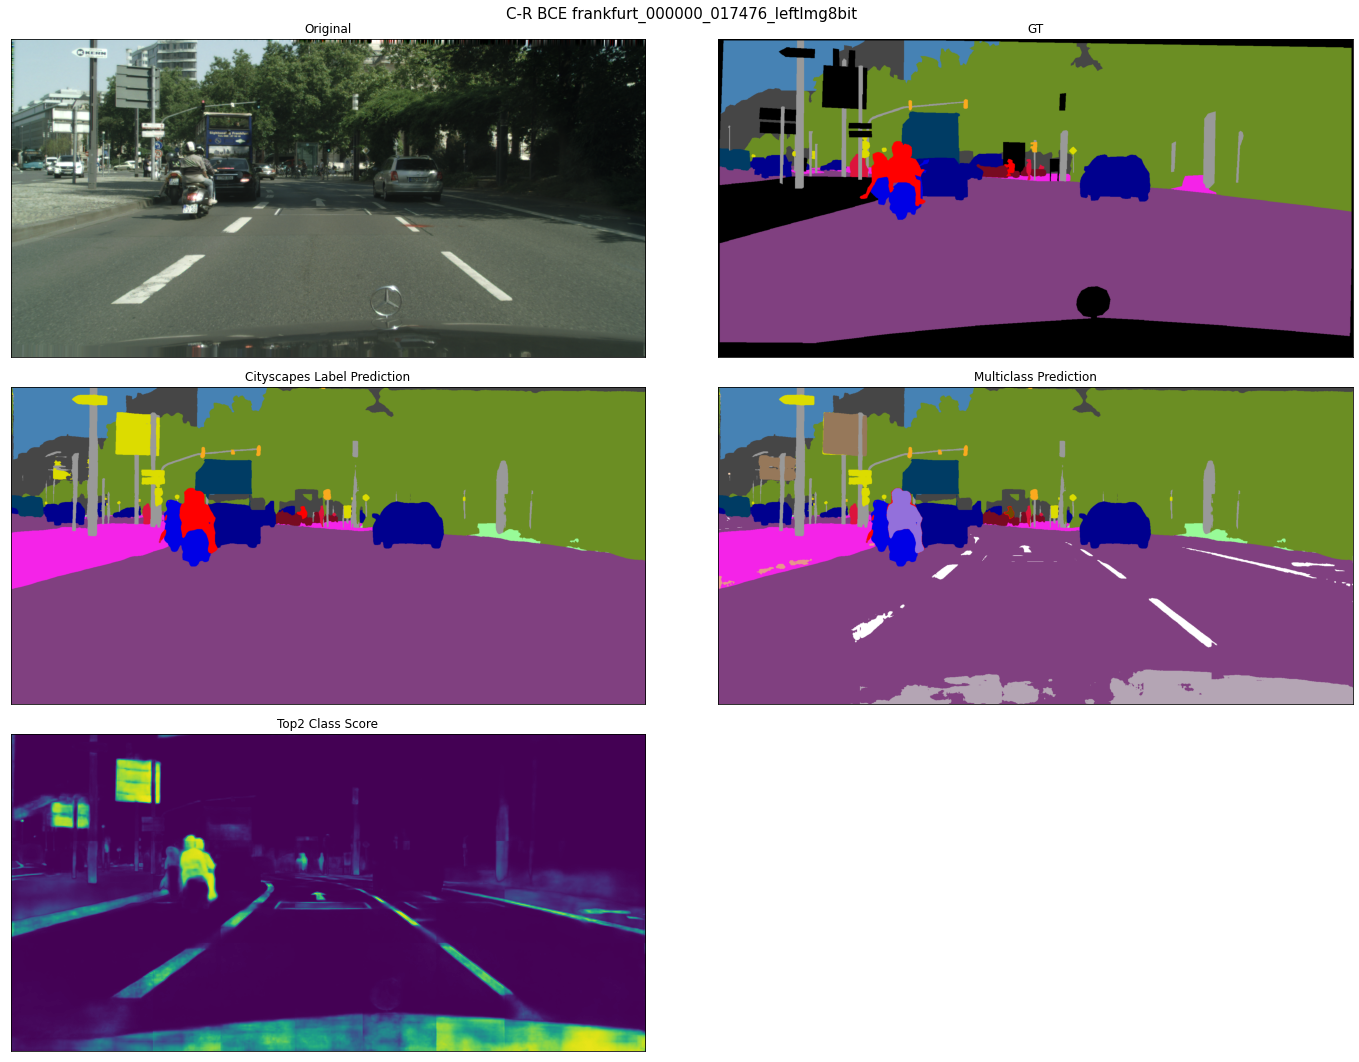

Classes in Final Model
Top1:  bird / motorcyclist / traffic sign (back) / street light / bicyclist / lane marking - general / curb / ego vehicle


In [30]:
with torch.no_grad():
    img, mask, name = dataset[idx]
    print(name)
    orig_img, _, _ = dataset.get_raw_samples(idx)
    orig_mask = colorize_mask(mask)
    img_cuda1 = img.clone().cuda(1).unsqueeze(0)
    img = img.cuda(0).unsqueeze(0)
    
    final_model_output = torch.sigmoid(sliding_crop_evaluation(final_model, 713, img))
    
    # Reduced output (Cityscapes label space)
    reduced_final_model_output = final_model_output.clone()
    reduced_final_model_output[:, non_cls_idxs, :, :] = -1
    reduced_pred = reduced_final_model_output.max(1)[1][0]
    reduced_pred_img = colorize_mask(reduced_pred)
    
    # remove obs-str-bar-fallback
    final_model_output[:, obs_fallback_idx, :, :] = 0
    
    # Non cityscapes prediction
    final_model_output[:, cls_idxs, :, :] = 0
    final_model_pred_vals, final_model_pred_idxs = final_model_output.topk(2, dim=1)
    final_model_top1_pred, final_model_top1_pred_vals = final_model_pred_idxs[0, 0], final_model_pred_vals[0, 0]
        
    multiclass_final_pred = reduced_pred.clone()
    multiclass_mask = final_model_top1_pred_vals >= sigmoid_threshold
    multiclass_final_pred[multiclass_mask] = final_model_top1_pred[multiclass_mask]
    multiclass_final_pred_img = colorize_mask(multiclass_final_pred, other_class_color_dict)
    visualize_images(num_rows=3, img_list=[orig_img, orig_mask, reduced_pred_img, multiclass_final_pred_img, 
                                           final_model_top1_pred_vals.cpu()],
                      names=['Original', 'GT', 'Cityscapes Label Prediction', 'Multiclass Prediction',
                             'Top2 Class Score'],
                      fig_size=(20, 15), title=f"C-R BCE {name}")
    
    # Save
    save_dir = '/home/dongwan/visualizations_uniseg/good_samples/final'
    save_path = os.path.join(save_dir, f'{name}_all.png')
    save_images(save_path, num_rows=3, img_list=[orig_img, orig_mask, reduced_pred_img, multiclass_final_pred_img, 
                                           final_model_top1_pred_vals.cpu()],
                      names=['Original', 'GT', 'Cityscapes Label Prediction', 'Multiclass Prediction',
                             'Top2 Class Score'],
                      fig_size=(20, 15), title=f"C-R BCE {name}")
    orig_img.save(os.path.join(save_dir, name + '.png'))
    orig_mask.save(os.path.join(save_dir, name + '_mask.png'))
    multiclass_final_pred_img.save(os.path.join(save_dir, name + '_multiclass_pred.png'))   
    reduced_pred_img.save(os.path.join(save_dir, name + '_pred.png'))
    scores_img = Image.fromarray((cm.viridis(final_model_top1_pred_vals.cpu()) * 255).astype(np.uint8))
    scores_img.save(os.path.join(save_dir, name + '_multiclass_scores.png'))

    print('Classes in Final Model')
    final_top1_unique = final_model_top1_pred[multiclass_mask].unique().cpu()
    
    top1_new_class_names = {all_dataset_categories[j.item()] for j in final_top1_unique} - \
                               set(cityscapes_categories)
    print("Top1: ", " / ".join(top1_new_class_names))

### CE Model

In [27]:
idx = 212

frankfurt_000001_061763_leftImg8bit


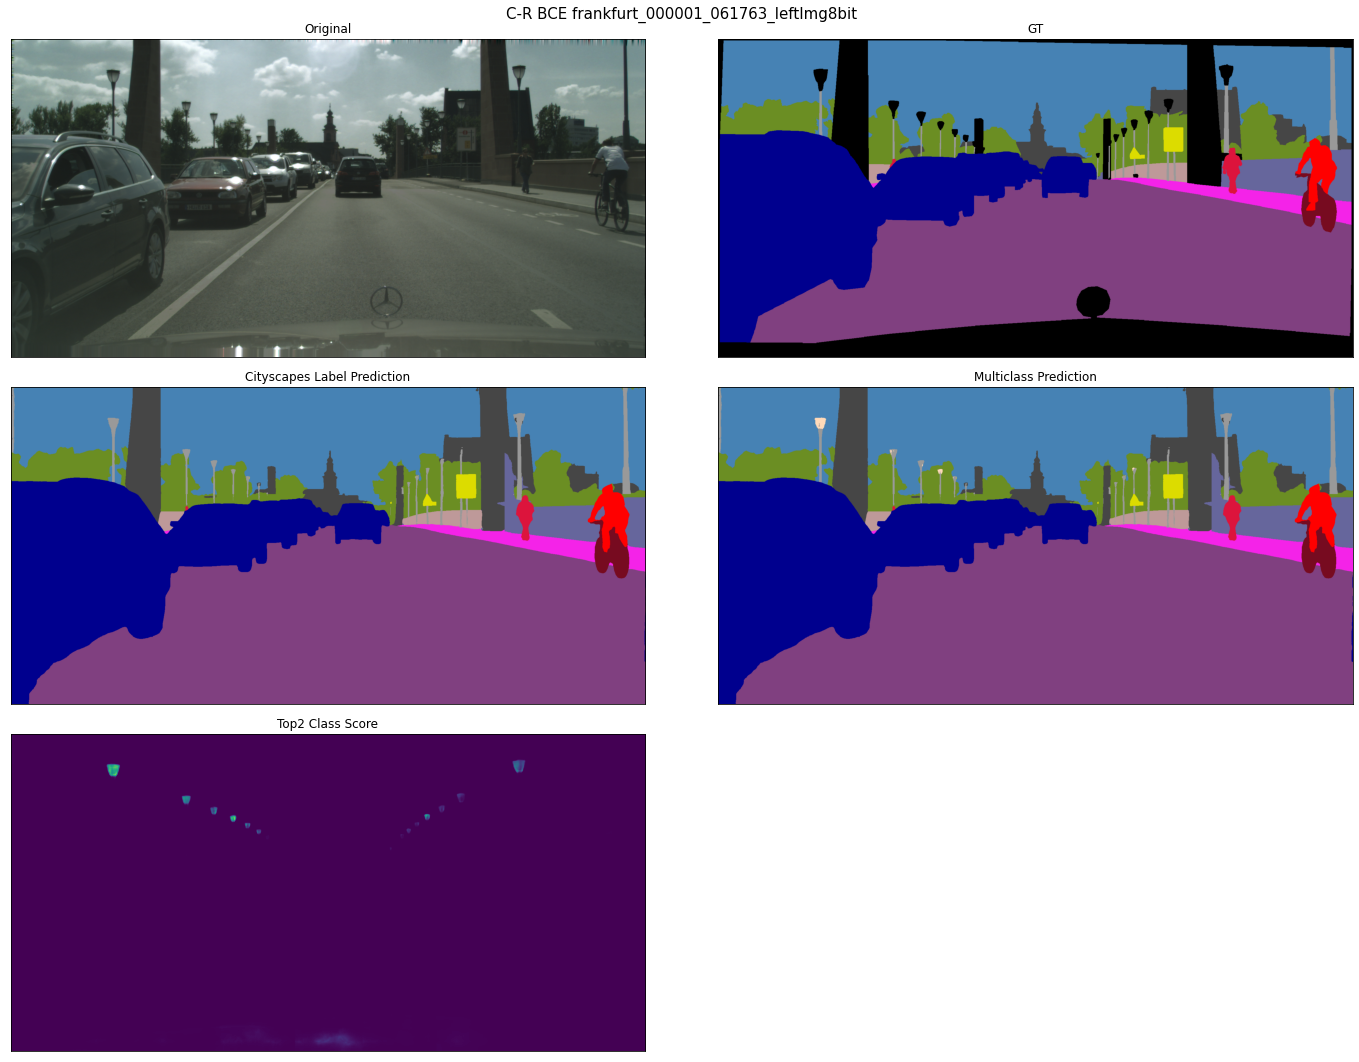

Classes in CE Model
Top1:  street light


In [28]:
with torch.no_grad():
    img, mask, name = dataset[idx]
    print(name)
    orig_img, _, _ = dataset.get_raw_samples(idx)
    orig_mask = colorize_mask(mask)
    img = img.cuda(1).unsqueeze(0)
    
    final_model_output = F.softmax(sliding_crop_evaluation(ce_model, 713, img, device='cuda:1'), dim=1)
    
    # Reduced output (Cityscapes label space)
    reduced_final_model_output = final_model_output.clone()
    reduced_final_model_output[:, non_cls_idxs, :, :] = -1
    reduced_pred = reduced_final_model_output.max(1)[1][0]
    reduced_pred_img = colorize_mask(reduced_pred)
    
    # remove obs-str-bar-fallback
    final_model_output[:, obs_fallback_idx, :, :] = 0
    
    # Non cityscapes prediction
    final_model_output[:, cls_idxs, :, :] = 0
    final_model_pred_vals, final_model_pred_idxs = final_model_output.topk(2, dim=1)
    final_model_top1_pred, final_model_top1_pred_vals = final_model_pred_idxs[0, 0], final_model_pred_vals[0, 0]
        
    multiclass_final_pred = reduced_pred.clone()
    multiclass_mask = final_model_top1_pred_vals >= sigmoid_threshold
    multiclass_final_pred[multiclass_mask] = final_model_top1_pred[multiclass_mask]
    multiclass_final_pred_img = colorize_mask(multiclass_final_pred, other_class_color_dict)
    visualize_images(num_rows=3, img_list=[orig_img, orig_mask, reduced_pred_img, multiclass_final_pred_img, 
                                           final_model_top1_pred_vals.cpu()],
                      names=['Original', 'GT', 'Cityscapes Label Prediction', 'Multiclass Prediction',
                             'Top2 Class Score'],
                      fig_size=(20, 15), title=f"C-R BCE {name}")
    
    #Save
    save_dir = '/home/dongwan/visualizations_uniseg/good_samples/ce'
    save_path = os.path.join(save_dir, f'{name}_all.png')
    save_images(save_path, num_rows=3, img_list=[orig_img, orig_mask, reduced_pred_img, multiclass_final_pred_img, 
                                           final_model_top1_pred_vals.cpu()],
                      names=['Original', 'GT', 'Cityscapes Label Prediction', 'Multiclass Prediction',
                             'Top2 Class Score'],
                      fig_size=(20, 15), title=f"C-R BCE {name}")
    orig_img.save(os.path.join(save_dir, name + '.png'))
    orig_mask.save(os.path.join(save_dir, name + '_mask.png'))
    multiclass_final_pred_img.save(os.path.join(save_dir, name + '_multiclass_pred.png'))   
    reduced_pred_img.save(os.path.join(save_dir, name + '_pred.png'))
    scores_img = Image.fromarray((cm.viridis(final_model_top1_pred_vals.cpu()) * 255).astype(np.uint8))
    scores_img.save(os.path.join(save_dir, name + '_multiclass_scores.png'))

    print('Classes in CE Model')
    final_top1_unique = final_model_top1_pred[multiclass_mask].unique().cpu()
    
    top1_new_class_names = {all_dataset_categories[j.item()] for j in final_top1_unique} - \
                               set(cityscapes_categories)
    print("Top1: ", " / ".join(top1_new_class_names))

In [ ]:
all_dataset_categories[57]

In [ ]:
all_dataset_categories.index('obs-str-bar-fallback')

In [ ]:
import matplotlib.cm as cm
Image.fromarray((cm.viridis(final_model_top2_pred_vals.cpu()) * 255).astype(np.uint8))

## Loop 

### Final Model 

In [ ]:
to_pil = transforms.ToPILImage()

In [ ]:
with torch.no_grad():
    for idx in tqdm(range(len(dataset))):
        img, mask, name = dataset[idx]
        name = name.replace('_leftImg8bit','')
        orig_img, _, _ = dataset.get_raw_samples(idx)
        orig_mask = colorize_mask(mask)
        img_cuda1 = img.clone().cuda(1).unsqueeze(0)
        img = img.cuda(0).unsqueeze(0)

        final_model_output = torch.sigmoid(sliding_crop_evaluation(final_model, 713, img))
        reduced_final_model_output = final_model_output.clone()
        reduced_final_model_output[:, non_cls_idxs, :, :] = -1

        final_model_pred_vals, final_model_pred_idxs = final_model_output.topk(2, dim=1)
        final_model_top1_pred, final_model_top1_pred_vals = final_model_pred_idxs[0, 0], final_model_pred_vals[0, 0]
        final_model_top2_pred, final_model_top2_pred_vals = final_model_pred_idxs[0, 1], final_model_pred_vals[0, 1]
        final_model_top2_pred_vals = final_model_top2_pred_vals.cpu()
        final_model_pred_img = colorize_mask(final_model_top1_pred)

        multiclass_final_pred = final_model_top1_pred.clone()
        multiclass_mask = final_model_top2_pred_vals >= sigmoid_threshold
        multiclass_final_pred[multiclass_mask] = final_model_top2_pred[multiclass_mask]
        multiclass_final_pred_img = colorize_mask(multiclass_final_pred)
        reduced_pred = reduced_final_model_output.max(1)[1].cpu()[0]
        reduced_pred_img = colorize_mask(reduced_pred)
        
#         save_dir = os.path.join(f'/home/dongwan/visualizations_uniseg/{dataset_name}/final_model')
        save_dir = os.path.join(f'/home/dongwan/visualizations_uniseg/{dataset_name}/bcenull_model')
        save_path = os.path.join(save_dir, 'combined', f"{name + '_all.png'}")
        save_images(num_rows=3, img_list=[orig_img, orig_mask, final_model_pred_img, multiclass_final_pred_img,
                                                reduced_pred_img, final_model_top2_pred_vals],
                          names=['Original', 'GT', 'Final Model Prediction', 'Multiclass Prediction',
                                'Reduced Label Prediction', 'Top2 Class Score'],
                          fig_size=(20, 15), title=f"C-R BCE {name}", save_path=save_path)
        orig_img.save(os.path.join(save_dir, 'single_imgs', name + '.png'))
        orig_mask.save(os.path.join(save_dir, 'single_imgs', name + '_mask.png'))
        final_model_pred_img.save(os.path.join(save_dir, 'single_imgs', name + '_pred_top1_all.png'))
        multiclass_final_pred_img.save(os.path.join(save_dir, 'single_imgs', name + '_multiclass.png'))   
        reduced_pred_img.save(os.path.join(save_dir, 'single_imgs', name + '_pred_reduced.png'))
        to_pil(final_model_top2_pred_vals).save(os.path.join(save_dir, 'single_imgs', name + '_top2_pred_vals.png'))


In [ ]:
with torch.no_grad():
    for idx in tqdm(range(len(dataset))):
        img, mask, name = dataset[idx]
        name = name.replace('_leftImg8bit','')
        orig_img, _, _ = dataset.get_raw_samples(idx)
        orig_mask = colorize_mask(mask)
        img = img.cuda(1).unsqueeze(0)

        final_model_output = F.softmax(sliding_crop_evaluation(ce_model, 713, img, device='cuda:1'), dim=1)
        reduced_final_model_output = final_model_output.clone()
        reduced_final_model_output[:, non_cls_idxs, :, :] = -1

        final_model_pred_vals, final_model_pred_idxs = final_model_output.topk(2, dim=1)
        final_model_top1_pred, final_model_top1_pred_vals = final_model_pred_idxs[0, 0], final_model_pred_vals[0, 0]
        final_model_top2_pred, final_model_top2_pred_vals = final_model_pred_idxs[0, 1], final_model_pred_vals[0, 1]
        final_model_top2_pred_vals = final_model_top2_pred_vals.cpu()
        final_model_pred_img = colorize_mask(final_model_top1_pred)

        multiclass_final_pred = final_model_top1_pred.clone()
        multiclass_mask = final_model_top2_pred_vals >= sigmoid_threshold
        multiclass_final_pred[multiclass_mask] = final_model_top2_pred[multiclass_mask]
        multiclass_final_pred_img = colorize_mask(multiclass_final_pred)
        reduced_pred = reduced_final_model_output.max(1)[1].cpu()[0]
        reduced_pred_img = colorize_mask(reduced_pred)
        
        save_dir = os.path.join(f'/home/dongwan/visualizations_uniseg/{dataset_name}/ce_model')
        save_path = os.path.join(save_dir, 'combined', f"{name + '_all.png'}")
        save_images(num_rows=3, img_list=[orig_img, orig_mask, final_model_pred_img, multiclass_final_pred_img,
                                                reduced_pred_img, final_model_top2_pred_vals],
                          names=['Original', 'GT', 'Final Model Prediction', 'Multiclass Prediction',
                                'Reduced Label Prediction', 'Top2 Class Score'],
                          fig_size=(20, 15), title=f"CE {name}", save_path=save_path)
        orig_img.save(os.path.join(save_dir, 'single_imgs', name + '.png'))
        orig_mask.save(os.path.join(save_dir, 'single_imgs', name + '_mask.png'))
        final_model_pred_img.save(os.path.join(save_dir, 'single_imgs', name + '_pred_top1_all.png'))
        multiclass_final_pred_img.save(os.path.join(save_dir, 'single_imgs', name + '_multiclass.png'))   
        reduced_pred_img.save(os.path.join(save_dir, 'single_imgs', name + '_pred_reduced.png'))
        to_pil(final_model_top2_pred_vals).save(os.path.join(save_dir, 'single_imgs', name + '_top2_pred_vals.png'))

## Sliding Crop Eval - run first 

In [16]:
## RUN THIS FIRST
def sliding_crop_evaluation(model, crop_size, image, num_classes=70, device='cuda:0'):
    b, c, h, w = image.size()
    all_pred = torch.zeros(b, num_classes, h, w).to(device)
    overlap = torch.zeros(b, num_classes, h, w).to(device)
    num_horizontals = (w // crop_size) + 1
    num_verticals = (h // crop_size) + 1
    if w % crop_size == 0:
        num_horizontals -= 1
    if h % crop_size == 0:
        num_verticals -= 1
    overlap_w = num_horizontals * crop_size - w
    overlap_h = num_verticals * crop_size - h
    overlap_w_per_crop = overlap_w // (num_horizontals - 1)
    overlap_h_per_crop = overlap_h // (num_verticals - 1)
    for j in range(num_verticals):
        start_x = 0
        start_y = crop_size * j - overlap_h_per_crop * j
        for i in range(num_horizontals):
            curr_x = start_x + crop_size
            curr_y = start_y + crop_size
            if curr_x > w:
                start_x = w - crop_size
                curr_x = w
            if curr_y > h:
                start_y = h - crop_size
                curr_y = w
            curr_img = image[:, :, start_y:curr_y, start_x:curr_x]
            curr_pred = model(curr_img)[0]
            all_pred[:, :, start_y:curr_y, start_x:curr_x] += curr_pred
            overlap[:, :, start_y:curr_y, start_x:curr_x] += 1
            start_x = curr_x - overlap_w_per_crop
    return all_pred / overlap